In [2]:
import pandas as pd
import recordlinkage as rl
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pyarrow
import dask.dataframe as dd
# get CPU count
import multiprocessing
CPU_COUNT = multiprocessing.cpu_count()

def attach_ori_feature(to_attach, to_attach_recid_left, to_attach_recid_right, left_df, right_df, suffixes):
    to_attach = to_attach.merge(left_df, left_on = to_attach_recid_left, right_on = 'recid', how = 'left')
    to_attach = to_attach.merge(right_df, left_on = to_attach_recid_right, right_on = 'recid', how = 'left', suffixes = suffixes)
    return to_attach

def plot_feature_importance(fields, feature_importances):
    df = pd.DataFrame({"Feature": fields, "Importance": feature_importances})
    df = df.sort_values("Importance", ascending=False)
    ax = df.plot(kind='bar', x='Feature', y='Importance', legend=None)
    ax.xaxis.set_label_text("")
    plt.tight_layout()
    plt.show()
import psutil
# Function to report RAM usage
def report_ram_usage():
    process = psutil.Process()
    ram_usage = process.memory_info().rss / (1024 ** 2)  # in MB
    # print(f"Current RAM usage: {ram_usage:.2f} MB")
    # human readable GiB
    print(f"Current RAM usage: {ram_usage / 1024:.2f} GiB")

# Report RAM before starting
report_ram_usage()

/users/xiet13/.local/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Current RAM usage: 0.33 GiB


## read modern UK (patent-industry already paired up)

In [3]:
# df = pd.read_csv("../int_data/all_patents_pred_conflict_resolved_bool_threshold_0_9999.csv")
df = pd.read_csv("../ori_data/Modern_UK_Patents.csv")


AttributeError: 'DataFrame' object has no attribute 'ind95us'

In [26]:
# modern UK stats (patent-industry already paired up)
df.shape[0], df.publicationnumber.nunique(), df.industry_nacerev2.map(lambda x:len(str(x))).value_counts(dropna = False) # One industry per patent

(30646,
 30646,
 industry_nacerev2
 4    30272
 3      374
 Name: count, dtype: int64)

In [16]:
df.title.value_counts() # Only 189 rows got title in the description (or not in it?) -> We don't need to filter Title out from description

title
A FAN ASSEMBLY                                                                                       68
A HAND HELD APPLIANCE                                                                                44
PROCESS                                                                                              43
VEHICLE CONTROL SYSTEM AND METHOD                                                                    42
A FAN                                                                                                40
                                                                                                     ..
A HEAD-MOUNTABLE DISPLAY WITH GESTURE RECOGNITION                                                     1
A RELAY DEVICE, METHOD AND COMPUTER PROGRAM                                                           1
ELECTRON BEAM GENERATING APPARATUS AND METHODS OF FORMING AN EMITTER                                  1
ELECTRON BEAM GENERATING APPPARATUS AND ELECTRON EMITTERS 

In [27]:
df.description.map(len).value_counts(dropna=False)

description
20559    6
863      6
1075     6
970      6
30584    6
        ..
15370    1
11394    1
12018    1
14776    1
17121    1
Name: count, Length: 23987, dtype: int64

## Clean patents


In [26]:
# Authors_US.csv and Authors_wide_US.csv
# Authors_wide_US_csv = name_info[['publicationnumber', 'name']].groupby('publicationnumber').agg(
#     {'name': lambda x: ', '.join([str(i) for i in x if pd.notna(i)]) if not x.empty else None}
# ).reset_index()
# Authors_wide_US_csv.name.map(len).hist()
# Authors_US_csv = name_info[['publicationnumber', 'inventor_no', 'name']]

# Authors_US_csv.to_csv('../int_data/Authors_US.csv', index = False)
# Authors_wide_US_csv.to_csv('../int_data/Authors_wide_US.csv', index = False)

In [27]:
# # authors, occupation strings and titles

# Authors_US_csv = pd.read_csv('../int_data/Authors_US.csv')
# Authors_wide_US_csv = pd.read_csv('../int_data/Authors_wide_US.csv')

# name_info = pd.read_pickle(f'../int_data/sub_patents_4omini_ver0_2_extrac_first_600_chars_309035_docs.pkl')
# Occupations = pd.read_csv("../ori_data/Occupation_string3.csv")
# Titles = pd.read_csv("../ori_data/Titles.csv")



In [40]:
# Is it clean already?
## No author names, no occupation strings
df.description.value_counts()[:5] # HTML elements present

description
<description lang="en" load-source="lhip" data-format="original"><p>Dispensing Mechanism for a Medical Device</p><p>The present invention relates to a dispensing mechanism for administering a dosage of a medicament. The present invention also relates to a medical device comprising a dispensing mechanism, an injection device comprising a dispensing mechanism and an inhaler comprising a dispensing mechanism.</p><p>Medical devices for administering medicament are known, for example liquid solutions or powders can be delivered to a user or patient using injection devices or powder inhalers respectively.</p><p>One such medical device for administering a liquid solution is an injection device comprising a dispensing mechanism in which the dosage to be administered may be set by a dosage button moveable by a user or patient. A subsequent further movement of the dosage button, typically in the proximal direction of the device, i.e. in a direction towards an injection site of the de

<Axes: >

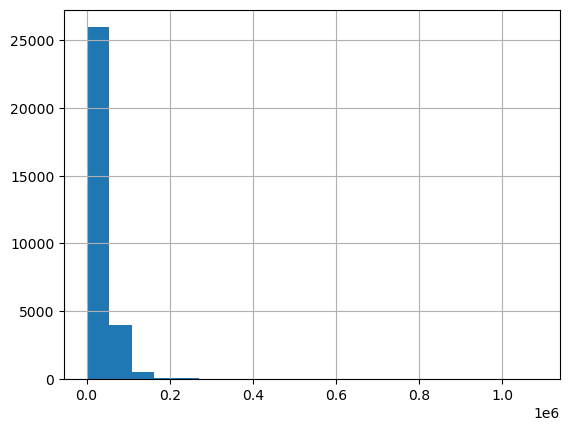

In [35]:
df.description.map(len).hist(bins = 20)

In [36]:
data = df
data

,publicationnumber,publicationdate,title,description,industry_nacerev2
0,GB2536787A,28/09/2016,PULTRUSION APPARATUS,"<description lang=""en"" load-source=""lhip"" data...",2229
1,GB2508787A8,10/09/2014,STABLE NON-AQUEOUS ELECTROLYTE PROMOTING IDEAL...,"<abstract lang=""en"" load-source=""national-offi...",4511
2,GB2508787A,11/06/2014,STABLE NON-AQUEOUS ELECTROLYTE PROMOTING IDEAL...,"<abstract lang=""en"" load-source=""national-offi...",4511
3,GB2501821B,14/09/2016,MS/MS ANALYSIS USING ECD OR ETD FRAGMENTATION,"<description lang=""en"" load-source=""lhip"" data...",8541
4,GB2511760A,17/09/2014,IMPROVEMENTS RELATING TO TEST DEVICES,"<description lang=""en"" load-source=""lhip"" data...",6420
...,...,...,...,...,...
30641,GB2503578A,01/01/2014,METHOD AND SYSTEM FOR COUPLING RESERVOIR AND S...,"<description lang=""en"" load-source=""lhip"" data...",1920
30642,GB2492218A,26/12/2012,VIRTUAL MICROSCOPY,"<description lang=""en"" load-source=""lhip"" data...",3250
30643,GB2487971A,15/08/2012,SKIN SUTURE INSERTION APPARATUS AND DRAIN SECU...,"<description lang=""en"" load-source=""lhip"" data...",3250
30644,GB2477687B,10/04/2013,X-RAY MARKER,"<description lang=""en"" load-source=""lhip"" data...",3250


In [41]:
occupations

,term,hisco
0,LABOURER,HISCO627
1,WINE,HISCO410
2,ABRASIVE FORMERS,HISCO892
3,ACCOUNT,HISCO331
4,ACCOUNTANT,HISCO110; HISCO331
...,...,...
5501,YARDMANS,HISCO999
5502,YARN SPINNERS,HISCO752
5503,YARN WINDERS,HISCO752
5504,YEOMANS,HISCO611


In [47]:
data.description.map(lambda x: 'LABOURER' in x.upper()).value_counts(), data.description.map(lambda x: 'ACCOUNTANT' in x.upper()).value_counts() # No occupation temrs occurring occppation context in description

(description
 False    30638
 True         8
 Name: count, dtype: int64,
 description
 False    30641
 True         5
 Name: count, dtype: int64)

In [50]:
data[data.description.map(lambda x: 'LABOURER' in x.upper())].description.iloc[0] # No occupation temrs occurring occppation context in description

'<description lang="en" load-source="lhip" data-format="original"><p>Vehicle</p><p>The present invention relates to a vehicle, in particular a working vehicle.</p><p>Known working vehicles, such as back hoe loaders have a materials handling implement such as a loading shovel mounted on the front of the machine and a further materials handling implement such as a back hoe, mounted on the back of a machine.</p><p>When the operator wishes to use the loading shovel the seat is orientated in a forwards facing direction and the operator can use controls such as the steering wheel, a foot brake, a foot clutch, a foot accelerator, a gear box having forward and reverse gears, and hand operated controls to lift and lower a loading arm and crowd or dump the loading shovel in order to manoeuvre material.</p><p>When it is necessary to move the back hoe loader from one location to another location, typically via public highway, the loading shovel will be lifted above ground level and the back hoe lo

In [52]:
import pandas as pd
import os
import re
import nltk
from nltk.stem import WordNetLemmatizer

# Download WordNet data from NLTK
nltk.download('wordnet')

############  1.0. Selection based on localised inventors  ############

############ 1.1 Data ############
# # Load CSV files containing authors, titles, and occupations information
# inventors = pd.read_csv("../ori_data/Authors.csv")
# inventors.rename(columns={'publicationnumber': 'i', 'name':'names'}, inplace=True)

# inventors_wide = pd.read_csv('../ori_data/Authors_wide.csv')
# inventors_wide.rename(columns={'publicationnumber': 'i', 'name':'names'}, inplace=True)

# # titles = pd.read_csv("../ori_data/Titles.csv")
# # titles.rename(columns={'ID_patent': 'i'}, inplace=True)
# # Only 189 rows got title in the description (or not in it?) -> We don't need to filter Title out from description

# # Load occupation data
# occupations = pd.read_csv("../ori_data/Occupation_string3.csv")

############ 1.2 Clean occupation titles ############
# Initialize lemmatizer for singularizing terms
lemmatizer = WordNetLemmatizer()

# def clean_term(term):
#     # Remove specific characters, numbers, and extra spaces from occupation terms
#     term = re.sub(r"- ", "", term)                    # Remove hyphens
#     term = re.sub(r"[[:punct:]]", " ", term)           # Remove punctuation
#     term = re.sub(r"([0-9]+)", "", term)              # Remove numbers
#     term = term.upper()                                  # Convert to uppercase
#     term = lemmatizer.lemmatize(term)                    # Convert to singular form
#     term = re.sub(r"BRIDGE", "", term)                # Remove specific word "BRIDGE"
#     term = re.sub(r"ETC", "", term)                   # Remove specific word "ETC"
#     term = re.sub(r"\s+", " ", term).strip()         # Remove extra spaces and trim
#     return term

# # # Apply cleaning function to occupation terms
# # occupations['term'] = occupations['term'].apply(clean_term)

# # Create a copy of occupations and convert terms to plural form
# def pluralize_term(term):
#     # Here, we simply add an 'S' to pluralize; consider using a more sophisticated pluralizer if needed
#     return term + 'S'

# occupations2 = occupations.copy()
# occupations2['term'] = occupations2['term'].apply(pluralize_term)

# # Combine original and pluralized occupation terms into a single dataframe
# occupations = pd.concat([occupations, occupations2], ignore_index=True)

# # Remove duplicate occupation terms
# occupations.drop_duplicates(subset='term', inplace=True)

# # Remove any rows with empty occupation terms
# occupations = occupations[occupations['term'] != '']

############ 1.3 Clean inventor names ############
# # Fill missing values in inventor names
# inventors['names'] = inventors['names'].fillna('')
# inventors_wide['names'] = inventors_wide['names'].fillna('')

# # Function to clean inventor names
# def clean_names(name):
#     name = re.sub(r"- ", "", name)                    # Remove hyphens
#     name = re.sub(r"[^[:punct:],]", " ", name)        # Remove non-punctuation characters
#     name = re.sub(r"([0-9]+)", "", name)              # Remove numbers
#     name = name.upper()                                  # Convert to uppercase
#     name = re.sub(r"\s+", " ", name).strip()         # Remove extra spaces and trim
#     return name

# # Apply cleaning function to inventor names
# inventors['names'] = inventors['names'].apply(clean_names)
# inventors_wide['names'] = inventors_wide['names'].apply(clean_names)

############ 1.4 Clean patent titles ############ Do we need to clean for titles? Not necessarily
# Fill missing values in patent titles
data['title'] = data['title'].fillna('')

# Function to clean patent titles
def clean_titles(title):
    title = re.sub(r"<RTI> & </RTI>", "", title)      # Remove specific tags
    title = re.sub(r"</?RTI>", "", title)             # Remove RTI tags
    title = re.sub(r"~", "", title)                   # Remove tilde characters
    title = re.sub(r"- ", "", title)                  # Remove hyphens
    title = re.sub(r"[[:punct:]]", " ", title)        # Remove punctuation
    title = title.upper()                                # Convert to uppercase
    title = re.sub(r"\s+", " ", title).strip()       # Remove extra spaces and trim
    return title

# Apply cleaning function to patent titles
data['title'] = data['title'].apply(clean_titles)

# Fill missing values in descriptions
data['description'] = data['description'].fillna('')
data['description'] = data['description'].apply(lambda x: re.sub(r"([0-9]+)", "", x))  # Remove numbers from description

############ 1.5 Merge ############
# Rename "Patent_ID" column to "i"
data = data.rename(columns={'patent_id': 'i'})

# Merge data with inventors_wide and titles datasets
# data = pd.merge(data, inventors_wide, on='i')
# data = pd.merge(data, titles, on='i')

# Remove rows with 'NA' in the description
data = data[data['description'] != 'NA']

# Word count
word_count = data['description'].str.split().str.len().sum()
word_count_df = pd.DataFrame({'w1': [word_count]})

print("Word Count (W1):", word_count)

# ############ 2 Merge Inventors: from 156,913 to 113,512 ############
# found_inventors = pd.read_csv(os.path.join(out_path, "Localised_inventors_v3.csv"))
# found_inventors.rename(columns={found_inventors.columns[0]: 'i'}, inplace=True)

# # Merge data with found inventors
# data = pd.merge(data, found_inventors, on='i')

# # Word count after merging inventors
# word_count = data['description'].str.split().str.len().sum()
# word_count_df['w2'] = word_count

# print("Word Count (W2):", word_count)

############ 3. First cleaning ############
# Function to clean descriptions
def clean_description(description):
    # Remove HTML tags
    description = re.sub(r"<[^>]+>", " ", description)
    
    # Remove specific tags and placeholders
    description = re.sub(r"<RTI> & </RTI>", "", description)      
    description = re.sub(r"</?RTI>", "", description)            
    description = re.sub(r"~", "", description)                
    description = re.sub(r"- ", "", description)               
    
    # Remove punctuation
    description = re.sub(r"[[:punct:]]", " ", description)      

    # Convert to uppercase
    description = description.upper()                                
    
    # Remove extra spaces and trim
    description = re.sub(r"\s+", " ", description).strip()       
    
    # Remove specific words
    keywords = ["IMG", "CLASS", "EMIREF", "ID", "CLSS"]
    for word in keywords:
        description = re.sub(fr"\b{word}\b", "", description)
    
    # Remove years and large numbers
    description = re.sub(r"\b\d{4,}\b", "", description)             

    # Remove common patent-specific terms
    terms_to_remove = [
        "PROVISIONAL", "PROVISIONL", "PROVIIONAL", "PRVISINAL", "COMPLETE",
        "SPECIFICATION", "SPECIFCATION", "PECIFICATION", "SPECIFICTION", "SPECIFICATIN",
        "IMPROVEMENTS", "IMPROVED", "THE NATURE OF THIS INVENTION", "TO BE AS FOLLOWS", "RTI"
    ]
    for term in terms_to_remove:
        description = re.sub(fr"\b{term}\b", "", description)

    # Remove specific patterns
    description = re.sub(r"\b000\b", "", description)        
    description = re.sub(r"\b\d+\b", "", description)      
    
    return description


# Apply cleaning function to descriptions
data['description'] = data['description'].apply(clean_description)

# Remove rows with empty descriptions
data = data[data['description'] != '']

# Word count after first cleaning
word_count = data['description'].str.split().str.len().sum()
word_count_df['w3'] = word_count

print("Word Count (W3):", word_count)


[nltk_data] Downloading package wordnet to /users/xiet13/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Word Count (W1): 162368822
Word Count (W3): 162097341


In [64]:
data.description

0        PULTRUSION APPARATUS FIELD OF INVENTION THE IN...
1        THE PRESENT INVENTION RELATES TO A LITHIUM -AI...
2        THE PRESENT INVENTION RELATES TO A LITHIUM -AI...
3        MS/MS ANALYSIS USING ECD OR ETD FRAGMENTATION ...
4         RELATING TO TEST DEVICES FIELD THE INVENTION ...
                               ...                        
30641    () TITLE OF THE INVENTION: METHOD AND SYSTEM F...
30642    • ·.·· INTELLECTUAL PROPERTY OFFICE DATE : OCT...
30643    -SKIN SUTURE INSERTION APPARATUS AND DRAIN SEC...
30644    X-RAY MARKER THE PRESENT INVENTION RELATES TO ...
30645    -SKIN SUTURE INSERTION APPARATUS AND DRAIN SEC...
Name: description, Length: 30646, dtype: object

In [65]:
data.to_pickle("../int_data/modern_UK_cleaning_section_3.pkl")
# data = pd.read_pickle("../int_data/modern_UK_cleaning_section_3.pkl")

<Axes: >

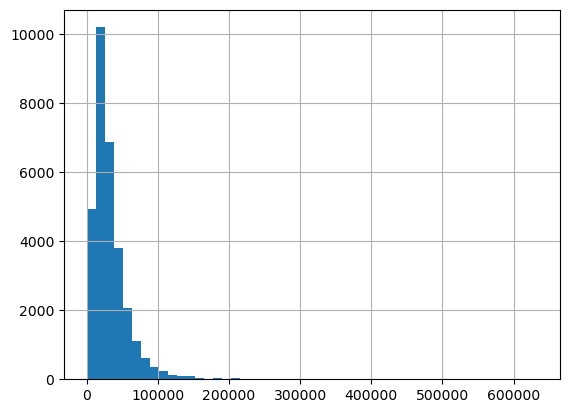

In [66]:
data.description.str.strip().map(len).hist(bins = 50)

In [69]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from tqdm import tqdm

# Download necessary NLTK data
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer

############ Step 4: Remove Intro, Location Names, Stopwords ############

# Assuming `data` DataFrame is already defined

# Remove intro text
data['pos2'] = data['description'].str.find('DO HEREBY DECLARE')
data['max'] = data['description'].str.len()
data['pos2'] = np.where(data['pos2'] == data['max'], 1, data['pos2'])
data['pos2'] = np.where(data['pos2'] > 500, 1, data['pos2'])
data['description'] = data.apply(lambda row: row['description'][row['pos2']:] if row['pos2'] > 0 else row['description'], axis=1)
data['description'] = data['description'].str.replace('DO HEREBY DECLARE', ' ', regex=False)

# # No ready-made town names to remove
# town_columns = ['street', 'city', 'county', 'state', 'region', 'full_address']
# town = pd.concat([data[col].dropna().rename('location') for col in town_columns], ignore_index=True).explode()
# towns_unique = town.unique()
# towns_set = set(town.lower() for town in towns_unique if pd.notna(town))  # Use lowercase for consistency

# Remove stopwords
stop_words = set(stopwords.words('english'))

# Combine all words to remove into a single set for efficient filtering
# unwanted_words = towns_set.union(stop_words)
unwanted_words = stop_words

# Define a function to remove unwanted words using naive filtering
def remove_unwanted_words_naive(description, unwanted_set):
    words = description.split()
    cleaned_words = [word for word in words if word.lower() not in unwanted_set]
    return ' '.join(cleaned_words)

# Apply removal of unwanted words with pandas `map` function
tqdm.pandas(desc="Removing unwanted words")
data['description'] = data['description'].progress_map(lambda desc: remove_unwanted_words_naive(desc, unwanted_words))

############ Step 5: Remove Duplicate Words Within Each Description ############

def remove_duplicates(description):
    return ' '.join(pd.unique(description.split()))

# Apply duplicate removal using `map` function
data['description'] = data['description'].map(remove_duplicates)

############ Step 6: Word Count After Removing Stopwords ############

# Calculate the total word count after all the removals
word_count = data['description'].str.split().str.len().sum()
word_count_df = pd.DataFrame()  # Assuming word_count_df needs to be defined
word_count_df['w4'] = [word_count]

print("Word Count (W4):", word_count)

############ Diagnosing Potential "No Spaces Between Words" Issue ############

# Explanation for no spaces between words:
# - When removing specific patterns or text, there is the risk of removing spaces alongside the target text.
# - We replaced each match with a space (' ') to ensure that even after the removal, words are still separated.
# - After all replacements, `.str.replace(r'\s+', ' ', regex=True).str.strip()` ensures proper spacing and removes any extra spaces.

# Final adjustments to remove extra spaces between words
data['description'] = data['description'].str.replace(r'\s+', ' ', regex=True).str.strip()

# Save the cleaned data if necessary
data.to_pickle("../int_data/modern_UK_cleaning_section_4.pkl")


Removing unwanted words: 100%|██████████| 30646/30646 [00:17<00:00, 1761.19it/s]
/tmp/ipykernel_2124/1751430126.py:50: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  return ' '.join(pd.unique(description.split()))


Word Count (W4): 24648694


<Axes: >

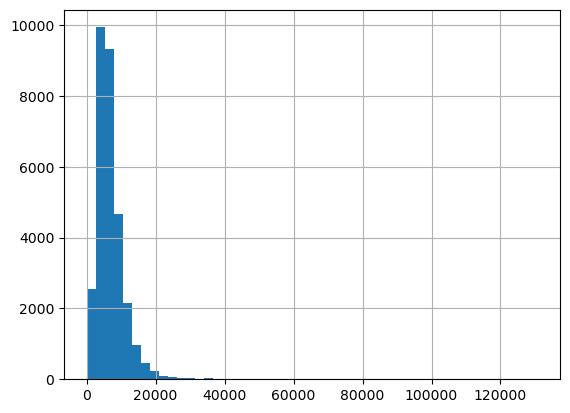

In [70]:
data.description.str.strip().map(len).hist(bins = 50)

In [71]:
data.to_pickle("../int_data/all_patent_cleaned_section_4.pkl")
import pandas as pd
data = pd.read_pickle("../int_data/all_patent_cleaned_section_4.pkl")

In [77]:
# Section 5-13: lemmateise and then remove
import pandas as pd
import os
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from joblib import Parallel, delayed
from tqdm import tqdm
import numpy as np
from scipy.sparse import csr_matrix

# Download necessary NLTK data
nltk.download('wordnet')
nltk.download('stopwords')

############ Step 5: Remove Low-Frequency Terms ############

# Create term frequency data
vectorizer = CountVectorizer()
x_counts = vectorizer.fit_transform(data['description'])

# Convert to sparse format to save memory
x_counts_sparse = csr_matrix(x_counts)

# Sum term frequencies in sparse format
term_freq = x_counts_sparse.sum(axis=0)

# Convert term frequencies to a DataFrame
term_freq_df = pd.DataFrame({
    'term': vectorizer.get_feature_names_out(),
    'freq': term_freq.A1
})
terms_to_remove = term_freq_df[term_freq_df['freq'] <= 2]['term'].tolist()

############ Step 6: Define Non-Technical Words (1) ############

non_technical_words_1 = [
    "RTI", "INVENTION", "END", "FIG", "FIGURE", "MEANS", "OPEN", "PROCESS", "PERMANENT",
    "TAKE", "MAKE", "THREAD", "STATE", "PROCEED", "THEREOF", "ORDINARY", "USUAL",
    # ... (add more words here)
]

# ############ Step 7: Load and Clean Inventor Names ############

# # Assuming 'input_path' is defined and points to the directory containing "Authors.csv"
# input_path = "./"  # Update this to the correct path

# # Load inventors file
# inventors = pd.read_csv("../int_data/Authors_US.csv")
# inventors.rename(columns={'publicationnumber': 'i'}, inplace=True)

# # Join with data
# inventors = pd.merge(inventors, data, on='i')

# # Clean inventor names
# def clean_inventor_names(name):
#     name = re.sub(r"- ", "", name)
#     name = re.sub(r"[[:punct:]]", " ", name)
#     name = name.upper()
#     name = re.sub(r"\s+", " ", name).strip()
#     return name

# inventors['names'] = inventors['names'].fillna('').apply(clean_inventor_names)
# inventors_unique = inventors['names'].unique().tolist()

############ Step 8: Define Additional Non-Technical Words ############

additional_non_technical_words = [
    "PERFORM", "ASCERTAIN", "ACCOMPANY", "RELATE", "OBJECT", "CARRY", "PASS",
    "CONSIST", "COUNTY", "EFFECT", "REFERENCE", "UPPER", "REQUIRE", "PLAN",
    # ... (add more words here)
]

############ Step 9: Combine All Words to be Removed ############

# all_words_to_remove = set(terms_to_remove + non_technical_words_1 + additional_non_technical_words + inventors_unique)
all_words_to_remove = set(terms_to_remove + non_technical_words_1 + additional_non_technical_words)


############ Step 10: Lemmatize the Text ############

lemmatizer = WordNetLemmatizer()

def lemmatize_text(description):
    return ' '.join([lemmatizer.lemmatize(word) for word in description.split()])

# Apply lemmatization in parallel
tqdm.pandas(desc="Lemmatizing text")
data['description'] = Parallel(n_jobs=-1)(
    delayed(lemmatize_text)(desc) for desc in tqdm(data['description'], desc="Lemmatizing text")
)

############ Step 11: Remove All Unwanted Words in One Pass ############

def remove_unwanted_words(description, words_to_remove = all_words_to_remove):
    return ' '.join([word for word in description.split() if word not in words_to_remove])

# Apply removal in parallel
# tqdm.pandas(desc="Removing all undesired words")
# data['description'] = Parallel(n_jobs=-1)(
#     delayed(remove_unwanted_words)(desc, all_words_to_remove) for desc in tqdm(data['description'], desc="Removing all undesired words")
# )

tqdm.pandas(desc="Removing all undesired words")
data['description'] = data['description'].map(remove_unwanted_words)

############ Step 12: Optional - Remove Duplicates Within Each Cell ############

def remove_duplicates(description):
    return ' '.join(pd.unique(description.split()))

# Apply duplicate removal
data['description'] = data['description'].map(remove_duplicates)

## Extra
############ KEEP ONLY WORDS FOUND IN THE DICTIONARY ############
from nltk.corpus import words
import nltk
nltk.download('words')

dictionary = set([w.upper() for w in words.words()])

def keep_words_in_dict(s):
    return ' '.join([word for word in s.split() if word in dictionary])

data['description'] = data['description'].map(keep_words_in_dict)
data

############ Step 13: Save Final Data ############

# Assuming 'out_path' is defined for the output file path
out_path = "./"  # Update this to your desired output path
output_file = os.path.join(out_path, "../int_data/Input_patent_matrix_UK_modern.csv")
data.to_csv(output_file, index=False)
print(f"Data saved to {output_file}")

[nltk_data] Downloading package wordnet to /users/xiet13/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /users/xiet13/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Lemmatizing text: 100%|██████████| 30646/30646 [00:10<00:00, 3003.20it/s] 
/tmp/ipykernel_2124/1442264833.py:112: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  return ' '.join(pd.unique(description.split()))
[nltk_data] Downloading package words to /users/xiet13/nltk_data...
[nltk_data]   Package words is already up-to-date!


Data saved to ./../int_data/Input_patent_matrix_UK_modern.csv


In [78]:
data

,publicationnumber,publicationdate,title,description,industry_nacerev2,pos2,max
0,GB2536787A,28/09/2016,PULTRUSION APPARATUS,APPARATUS FIELD INLET SPREADER PRODUCT USE PAR...,2229,-1,53757
1,GB2508787A8,10/09/2014,STABLE NON-AQUEOUS ELECTROLYTE PROMOTING IDEAL...,PRESENT LITHIUM BATTERY NEGATIVE ELECTRODE ACT...,4511,-1,426
2,GB2508787A,11/06/2014,STABLE NON-AQUEOUS ELECTROLYTE PROMOTING IDEAL...,PRESENT LITHIUM BATTERY NEGATIVE ELECTRODE ACT...,4511,-1,426
3,GB2501821B,14/09/2016,MS/MS ANALYSIS USING ECD OR ETD FRAGMENTATION,ANALYSIS FRAGMENTATION BACKGROUND PRESENT METH...,8541,-1,30934
4,GB2511760A,17/09/2014,IMPROVEMENTS RELATING TO TEST DEVICES,TEST FIELD DIAGNOSTIC PARTICULAR INDIVIDUALLY ...,6420,-1,109693
...,...,...,...,...,...,...,...
30641,GB2503578A,01/01/2014,METHOD AND SYSTEM FOR COUPLING RESERVOIR AND S...,TITLE METHOD SYSTEM COUPLING RESERVOIR SURFACE...,1920,-1,1003
30642,GB2492218A,26/12/2012,VIRTUAL MICROSCOPY,INTELLECTUAL PROPERTY OFFICE DATE OCTOBER APPL...,3250,-1,80417
30643,GB2487971A,15/08/2012,SKIN SUTURE INSERTION APPARATUS AND DRAIN SECU...,SUTURE INSERTION APPARATUS DRAIN PRESENT SKIN ...,3250,-1,21990
30644,GB2477687B,10/04/2013,X-RAY MARKER,MARKER PRESENT PARTICULAR DETERMINE MAGNIFICAT...,3250,-1,22918


In [4]:
# data = pd.read_csv("../int_data/Input_patent_matrix_US.csv")

In [79]:
# Optional: Recalculate term frequencies after cleaning, if needed
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import csr_matrix

# Create term frequency data again after cleaning
vectorizer = CountVectorizer()
x_counts = vectorizer.fit_transform(data['description'])
x_counts_sparse = csr_matrix(x_counts)

# Sum term frequencies in sparse format
term_freq = x_counts_sparse.sum(axis=0)

# Convert term frequencies to a DataFrame
term_freq_df = pd.DataFrame({
    'term': vectorizer.get_feature_names_out(),
    'freq': term_freq.A1
})

# Display the cleaned term frequencies to verify
print(term_freq_df.head(20))

           term  freq
0            aa   369
1           aam     8
2         aaron     3
3            ab   383
4           aba     9
5          abac     1
6         abaca     1
7         aback     3
8        abacus     3
9         abaft     3
10      abandon    64
11    abandoned    98
12  abandonment    44
13        abase     9
14       abased     2
15       abasic     2
16     abatable     1
17        abate    21
18    abatement    65
19     abattoir     5


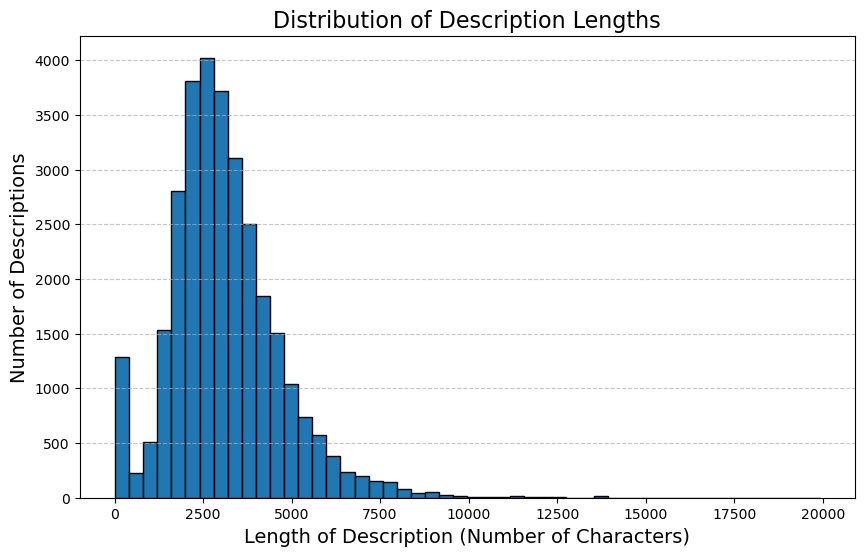

In [80]:
import matplotlib.pyplot as plt

# Step 1: Clean up the whitespace in each description and calculate the length
description_lengths = data['description'].str.strip().map(len)

# Step 2: Plot a histogram of the lengths of descriptions
plt.figure(figsize=(10, 6))
plt.hist(description_lengths, bins=50, edgecolor='black')

# Step 3: Labeling the axes and adding a title for clarity
plt.xlabel('Length of Description (Number of Characters)', fontsize=14)
plt.ylabel('Number of Descriptions', fontsize=14)
plt.title('Distribution of Description Lengths', fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.show()


In [81]:
data[data.description.map(len) < 2000].shape

(6332, 7)

In [82]:
data['description'][0]

'APPARATUS FIELD INLET SPREADER PRODUCT USE PARTICULARLY EXCLUSIVELY WIND ENERGY TURBINE BACKGROUND COMPOSITE FIBROUS REINFORCEMENT MATERIAL RESIN MATRIX BECOME INCREASING COMBINE EXCELLENT STRENGTH LOW FIRST CHOICE PARTICULAR AIRCRAFT NUMEROUS FABRICATION LIMITED POLYMERIC MATRICES AUTOCLAVE EITHER LABOR COSTLY PURELY METALLIC APPLICABLE MODERATE HIGH VOLUME RESULT STRUCTURALLY EFFICIENT DESIRED WEIGHT COMBINATION CONVENTIONAL PRODUCTION LIMITATION PRODUCE ELONGATED UNIFORM DUE PART NATURE LONG CONTINUOUS VARIOUS UNIT NATURALLY DIRECTION THERMOPLASTIC WIDELY STRUCTURAL POLYESTER BETTER PROVIDE L MECHANICAL PERFORMANCE RATIO COMPARABLE CANNOT SUBSEQUENTLY SHAPED YET NECESSARY CURE DIE ORDER BIND TOGETHER CREATE SYSTEM EMPLOYED RAPID GENERALLY UNSUITABLE PRIMARY LESS OPTIMAL LOWER FABRIC NECESSITY CURING INCOMPLETE IMPREGNATION ALSO MOISTURE LEADS COMMON WEAR TEAR ISSUE CONTACT ABRASIVE MAY PULL CONSTANT RATE FLOW LEAD SURFACE OBVIATE LEAST MITIGATE SUMMARY ACCORDING PROVIDED DEFINED ON

In [83]:
data

,publicationnumber,publicationdate,title,description,industry_nacerev2,pos2,max
0,GB2536787A,28/09/2016,PULTRUSION APPARATUS,APPARATUS FIELD INLET SPREADER PRODUCT USE PAR...,2229,-1,53757
1,GB2508787A8,10/09/2014,STABLE NON-AQUEOUS ELECTROLYTE PROMOTING IDEAL...,PRESENT LITHIUM BATTERY NEGATIVE ELECTRODE ACT...,4511,-1,426
2,GB2508787A,11/06/2014,STABLE NON-AQUEOUS ELECTROLYTE PROMOTING IDEAL...,PRESENT LITHIUM BATTERY NEGATIVE ELECTRODE ACT...,4511,-1,426
3,GB2501821B,14/09/2016,MS/MS ANALYSIS USING ECD OR ETD FRAGMENTATION,ANALYSIS FRAGMENTATION BACKGROUND PRESENT METH...,8541,-1,30934
4,GB2511760A,17/09/2014,IMPROVEMENTS RELATING TO TEST DEVICES,TEST FIELD DIAGNOSTIC PARTICULAR INDIVIDUALLY ...,6420,-1,109693
...,...,...,...,...,...,...,...
30641,GB2503578A,01/01/2014,METHOD AND SYSTEM FOR COUPLING RESERVOIR AND S...,TITLE METHOD SYSTEM COUPLING RESERVOIR SURFACE...,1920,-1,1003
30642,GB2492218A,26/12/2012,VIRTUAL MICROSCOPY,INTELLECTUAL PROPERTY OFFICE DATE OCTOBER APPL...,3250,-1,80417
30643,GB2487971A,15/08/2012,SKIN SUTURE INSERTION APPARATUS AND DRAIN SECU...,SUTURE INSERTION APPARATUS DRAIN PRESENT SKIN ...,3250,-1,21990
30644,GB2477687B,10/04/2013,X-RAY MARKER,MARKER PRESENT PARTICULAR DETERMINE MAGNIFICAT...,3250,-1,22918


In [8]:
# import pandas as pd
# import os
# import re
# import nltk
# from nltk.corpus import stopwords
# from nltk.stem import WordNetLemmatizer
# import numpy as np
# from sklearn.feature_extraction.text import CountVectorizer

# # Download necessary NLTK data
# nltk.download('wordnet')
# nltk.download('stopwords')

# ############ 5. REMOVE TERMS THAT APPEAR ONCE OR TWICE ############
# # Create term frequency data
# vectorizer = CountVectorizer()
# x_counts = vectorizer.fit_transform(data['description'])
# # term_freq_df = pd.DataFrame({'term': vectorizer.get_feature_names_out(), 'freq': x_counts.toarray().sum(axis=0)})

# # # Remove terms that appear once or twice
# from scipy.sparse import csr_matrix
# import pandas as pd

# # Convert to sparse format to save memory
# x_counts_sparse = csr_matrix(x_counts)

# # Sum term frequencies in sparse format
# term_freq = x_counts_sparse.sum(axis=0)

# # Convert term frequencies to a DataFrame
# term_freq_df = pd.DataFrame({
#     'term': vectorizer.get_feature_names_out(),
#     'freq': term_freq.A1  # Converts sparse matrix to array for a single row
# })

# print(term_freq_df)
# terms_to_remove = term_freq_df[term_freq_df['freq'] <= 2]['term'].tolist()

# data['description'] = data['description'].apply(lambda x: ' '.join([word for word in x.split() if word not in terms_to_remove]))

# # Word count after removing low-frequency terms
# word_count = data['description'].str.split().str.len().sum()
# word_count_df['w5'] = word_count
# print("Word Count (W5):", word_count)

# ############ 6. REMOVE N MOST FREQUENT NON-TECHNICAL WORDS (1) ############
# # Remove specified non-technical words
# non_technical_words_1 = [
#     "RTI", "INVENTION", "END", "FIG", "FIGURE", "MEANS", "OPEN", "PROCESS", "PERMANENT", "TAKE", "MAKE", "THREAD", "STATE", "PROCEED", "THEREOF", "ORDINARY", "USUAL", "CREATE", "DO", "MODE", "TREAT", "ELIMINATE", "FREE", "PRODUCE", "PREFER", "BOX", "FEET", "TH", "INTRODUCE", "POSITION", "CLASS", "SIDE", "IMG", "EMIREF", "PROVIDED", "MANNER", "SHOWN", "PART", "SUITABLE", "FORM", "CONNECTED", "FORMED", "NATURE", "SECTION", "ENDS", "SPECIFICATION", "LOWER", "DECLARE", "IMPROVEMENTS", "IMPROVED", "IMPROVE", "ARRANGED", "VIEW", "FIXED", "PORTION", "CONTACT", "SECURED", "LINE", "MOVEMENT", "DESIRED", "FRONT", "BACK", "BOTTOM", "DEVICE", "COMPLETE", "CONSTRUCTION", "DRAWING", "ORDER", "VERTICAL", "HORIZONTAL", "MOUNTED", "ARRANGEMENT", "ATTACHED", "TIME", "DIRECTION", "PURPOSE", "ACTION", "PLACE", "SIMILAR", "FIGS", "STATEMENT"
# ]

# data['description'] = data['description'].apply(lambda x: ' '.join([word for word in x.split() if word not in non_technical_words_1]))

# # Word count after removing non-technical words
# word_count = data['description'].str.split().str.len().sum()
# word_count_df['w6'] = word_count
# print("Word Count (W6):", word_count)

# ############ 7. REMOVE INVENTOR NAMES ############
# inventors = pd.read_csv(os.path.join(input_path, "Authors.csv"))
# inventors.rename(columns={'ID_patent': 'i'}, inplace=True)
# inventors = pd.merge(inventors, data, on='i')

# # Clean inventor names
# def clean_inventor_names(name):
#     name = re.sub(r"- ", "", name)
#     name = re.sub(r"[[:punct:]]", " ", name)
#     name = name.upper()
#     name = re.sub(r"\s+", " ", name).strip()
#     return name

# inventors['names'] = inventors['names'].fillna('').apply(clean_inventor_names)
# inventors_unique = inventors['names'].unique().tolist()

# data['description'] = data['description'].apply(lambda x: ' '.join([word for word in x.split() if word not in inventors_unique]))

# # Word count after removing inventor names
# word_count = data['description'].str.split().str.len().sum()
# word_count_df['w7'] = word_count
# print("Word Count (W7):", word_count)

# ############ 8. LEMMATIZE THE TEXT ############
# lemmatizer = WordNetLemmatizer()
# data['description'] = data['description'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))
# data['description'] = data['description'].str.upper()

# # Remove non-technical words from the list V1 after lemmatizing
# V1 = [lemmatizer.lemmatize(word) for word in non_technical_words_1]
# V1 = [word.upper() for word in V1]
# data['description'] = data['description'].apply(lambda x: ' '.join([word for word in x.split() if word not in V1]))

# # Remove duplicates within each cell
# data['description'] = data['description'].apply(lambda x: ' '.join(pd.unique(x.split())))

# # Word count after lemmatizing
# word_count = data['description'].str.split().str.len().sum()
# word_count_df['w8'] = word_count
# print("Word Count (W8):", word_count)

# ############ 9. REMOVE WORDS WITH LESS THAN 3 LETTERS ############
# data['description'] = data['description'].apply(lambda x: ' '.join([word for word in x.split() if len(word) >= 3]))

# # Word count after removing short words
# word_count = data['description'].str.split().str.len().sum()
# word_count_df['w9'] = word_count
# print("Word Count (W9):", word_count)

# ############ 10. REMOVE N MOST FREQUENT NON-TECHNICAL WORDS (2) ############
# # Remove additional specified non-technical words
# additional_non_technical_words = [
#     "PERFORM", "ASCERTAIN", "ACCOMPANY", "RELATE", "OBJECT", "CARRY", "PASS", "CONSIST", "COUNTY", "EFFECT", "REFERENCE", "UPPER", "REQUIRE", "PLAN", "WORK", "ILLUSTRATE", "TOP", "SMALL", "PIECE", "REFER", "PRESENT", "APPLY", "CONNECTION", "OPOSITE", "ACT", "PROJECT", "LARGE", "HAND", "READILY", "CAUSE", "SEPARATE", "PREVENT", "ENGINEER", "LEAVE", "DISTANCE", "OBTAIN", "CENTRE", "THERETO", "SERVE", "LONGITUDINAL", "INCREASE", "REDUCE", "PARTLY", "COUJTY", "ALLOW", "SIMPLE", "REAIN", "CITY", "STREET", "AFORESAID", "HALF", "DIRECTLY", "DESCRIPTION", "MODIFY", "ADVANTAGE", "TRAVEL", "SUFFICIENTLY", "HERETOFORE", "EFFICIENT", "ENSURE", "REGULAR", "OVERCOME", "IMMEDIATELY", "PND", "DIRECTOR", "UNDERNEATH", "INTEND", "DRAWING", "PREFERABLY", "EMPLOY", "FIT", "SHAPE", "TURN", "CONSTRUCT", "MATERIAL", "SUPPORT", "UNDERSTAND", "MOVE", "SURFACE", "ADAPT", "REMOVE", "EXTEND", "SET", "LEVAVE", "OPPOSITE", "OPERATE", "OUTER", "RECEIVE", "CLOSE", "ENGAGE", "POINT", "OPERATION", "LENGTH", "CASE", "COVER", "PIN", "REPRESENT", "LETTER", "ENABLE", "SPACE", "REST", "BRING", "CONVENIENT", "HEREINAFET", "DRIVE", "RAISE", "DETAIL", "METHOD", "HOLD", "SUFFICIENT", "SIZE", "ENTER", "VARY", "CLAIM", "AIR", "FIND", "RUN", "DESCRIBE", "PERMIT", "ADJUST", "GREAT", "HOLE", "INSERT", "PROPER", "GIVE", "HANDLE", "MECHANISM", "HIGH", "RESULT", "COMMUNICATE", "INSTANCE", "FULLY", "LIE", "SLIGHTLY", "INSIDE"
# ]

# data['description'] = data['description'].apply(lambda x: ' '.join([word for word in x.split() if word not in additional_non_technical_words]))

# # Strip whitespace and trim descriptions
# data['description'] = data['description'].str.strip()

# # Stem the descriptions using WordNet lemmatizer for a simpler transformation
# from nltk.stem import PorterStemmer
# stemmer = PorterStemmer()
# data['description'] = data['description'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))

# # Remove duplicates within each cell again after stemming
# data['description'] = data['description'].apply(lambda x: ' '.join(pd.unique(x.split())))

# # Word count after removing most frequent words and stemming
# word_count = data['description'].str.split().str.len().sum()
# word_count_df['w10'] = word_count
# print("Word Count (W10):", word_count)

# ############ 11. KEEP ONLY WORDS FOUND IN THE DICTIONARY ############
# dictionary = pd.read_csv(os.path.join(input_path, "words_alpha.txt"), header=None, names=['word'])
# dictionary['word'] = dictionary['word'].str.upper()

# data['description'] = data['description'].apply(lambda x: ' '.join([word for word in x.split() if word in dictionary['word'].values]))

# # Word count after dictionary filtering
# word_count = data['description'].str.split().str.len().sum()
# word_count_df['w11'] = word_count
# print("Word Count (W11):", word_count)

# ############ 12. CONVERT DATAFRAME TO CORPUS ############
# # Write final data to CSV
# output_file = os.path.join(out_path, "Input_patent_matrix.csv")
# data.to_csv(output_file, index=False)
# print(f"Data saved to {output_file}")


[nltk_data] Downloading package wordnet to /users/xiet13/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /users/xiet13/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                                term  freq
0                                                 __   112
1                                                ___    45
2                                               ____    35
3                                              _____    31
4                                             ______    32
...                                              ...   ...
12385831   ώρεόεείοατιονformingpartofletterspatentno     1
12385832                                        ώριθ     1
12385833                                          ώτ     1
12385834                                  ώϊcliitcll     1
12385835  ώώώjawsoftheinstrumenttowhichthedevicesand     1

[12385836 rows x 2 columns]


NameError: name 'terms_to_remove' is not defined

In [84]:
# term_freq_df[term_freq_df.term.map(len)>12].sort_values('freq', ascending = True)[:60]
term_freq_df.sort_values('freq', ascending = False)[:60]

,term,freq
20022,one,29349
17568,may,29144
947,also,28422
23114,provided,28062
22709,present,27580
10191,example,27334
32510,used,27295
11010,first,27095
32509,use,26600
23113,provide,26297


## Calculating

In [ ]:
# Count the number of words in the 'description' column
data['strcount'] = data['description'].str.split().str.len()
# Filter the data based on the word count
# Too long or too short patents are filtered
data = data[(data['strcount'] > 10) & (data['strcount'] <= 500)].reset_index(drop = True)
data